## Регрессия 1D функции с помощью FFN

In [1]:
import os
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

np.random.seed(123)

%matplotlib inline

Using Theano backend.


### Строим обучающую и тестовую выборки для 1D функции

In [2]:
x = np.linspace(-3*np.pi, 3*np.pi, 500)
y = np.sin(x)

xy = np.array(list(zip(x, y)))

np.random.shuffle(xy)

train_ratio = 0.5

train_x, train_y, test_x, test_y = (xy[:int(len(xy) * train_ratio), 0],
                                    xy[:int(len(xy) * train_ratio), 1],
                                    xy[int(len(xy) * train_ratio):, 0],
                                    xy[int(len(xy) * train_ratio):, 1])

train_x_net = train_x.reshape((len(train_x), 1))
train_y_net = train_y.reshape((len(train_y), 1))
test_x_net = test_x.reshape((len(test_x), 1))
test_y_net = test_y.reshape((len(test_y), 1))

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

### Отображаем построенные данные

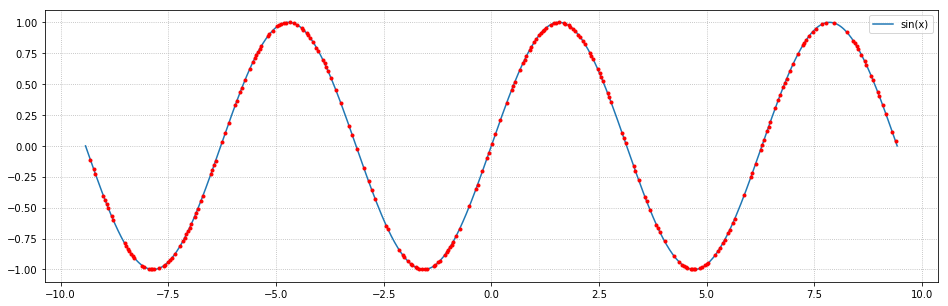

In [3]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, y)
ax.plot(train_x, train_y, '.r')
ax.grid(ls=':')
ax.legend(['sin(x)'])
plt.show()

### Построим модель нейронной сети и обучим ее

In [4]:
%%time
model = Sequential()
model.add(Dense(10, input_dim=1, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

Wall time: 479 ms


In [5]:
%%time
history = model.fit(train_x_net,
                    train_y_net,
                    validation_data=(test_x_net, test_y_net),
                    batch_size=10,
                    epochs=1500, verbose=0)

Wall time: 46.9 s


### Проверим работу нейронной сети

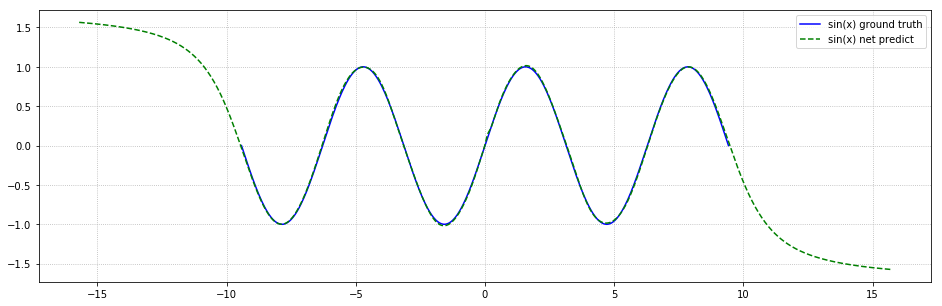

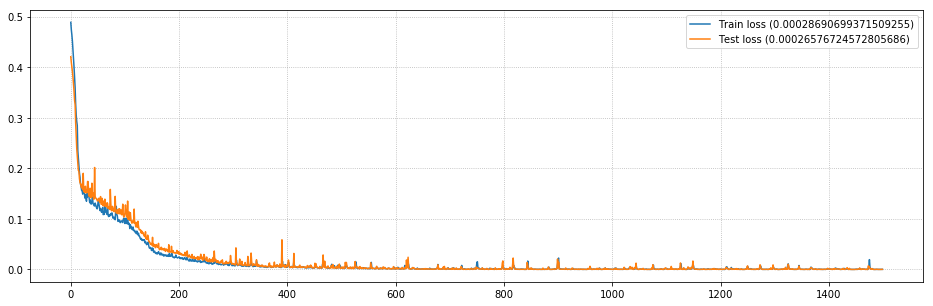

In [6]:
evaluate_x = np.linspace(-5*np.pi, 5*np.pi, 1000)
evaluate_y = model.predict(evaluate_x)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, y, 'b')
# ax.plot(train_x, train_y, '.r')
ax.plot(evaluate_x, evaluate_y, '--g')
ax.legend(['sin(x) ground truth', 'sin(x) net predict'])
ax.grid(ls=':')
plt.show()

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.legend(['Train loss ({})'.format(history.history['loss'][-1]), \
           'Test loss ({})'.format(history.history['val_loss'][-1])])
ax.grid(ls=':')
plt.show()

### Произведем настройку параметров нейронной сети с помощью KerasRegressor и GridSearchCV

In [7]:
batch_size = [10, 20, 40, 50]
epochs = [100, 200, 300, 500]
layers = [3, 4, 5]
neurons = [6, 8, 10]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
kernel_initializer = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal',
                      'he_uniform']

def create_model(layers=1, neurons=2):
    model = Sequential()
    model.add(Dense(neurons, input_dim=1, activation='tanh'))
    for i in range(layers):
        model.add(Dense(neurons, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

In [8]:
estimator = KerasRegressor(build_fn=create_model, epochs=500, batch_size=10, verbose=0)

param_grid = dict(layers=layers, neurons=neurons)

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=1)

grid_result = grid.fit(train_x_net, train_y_net)

In [9]:
means = grid_result.cv_results_['mean_test_score']
times = grid_result.cv_results_['mean_fit_time']
params = grid_result.cv_results_['params']

results = [(mean, time, param) for mean, param, time in zip(means, params, times)]

for d in sorted(results, key=lambda x: x[0]):
    print(d)